In [ ]:
# 사용자에게 증상에 대한 word를 입력받은 뒤, 가능한 눈관련 질환들을 classification해 준다.
# input : string
# output : percentage of each possible names of diseases

In [ ]:
# Drive mount
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
import os
import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from torch import nn
from torch.autograd import Variable
from torch.nn import Module, Conv3d, Parameter
from torch.autograd import Function
from torchvision import models
from torchvision import utils
import sys
import argparse
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage
from scipy.ndimage import zoom

import pandas as pd
%matplotlib inline
torch.manual_seed(551)
torch.cuda.manual_seed_all(551)
np.random.seed(551)

In [ ]:
pip install konlpy

In [ ]:
import nltk
import torchtext
from konlpy.tag import Komoran

유니코드 수정 u"한국어"

In [ ]:
# load train dataset 
data = pd.read_csv('/content/gdrive/My Drive/sth/heeju.csv',encoding='utf-8',error_bad_lines=False,engine='python') #utf-8 #latin1 #CP949
data

,disease,symptoms
0,안구건조증,눈이 뻑뻑 건조함 피로함 시림 건조안 눈물이 부족 눈물이 지나치게 증발한다 눈이 따...
1,녹내장,심한 안통 시력 저하 눈물 흘림 눈부심 안검연축 눈이 당김 각막 확장 각막 혼탁 시...
2,백내장,시력감퇴 눈 부심 빛이 퍼져보임 물체가 여러 개로 보임 사물의 색 왜곡 눈동자 뿌옇...
3,결막염,가려움 간지러움 눈의 발적 분비물 발생 눈꼽이 생김 눈꼽 발생 이물감 눈 통증 안통...
4,다래끼,눈꺼풀 부종 충혈 안통 간지러움 까끌까끌함 이물감 눈에 아몬드가 있는 듯함 눈 통증...
5,당뇨 망막병증,시야 흐림 광시증 눈을 감아도 빛이 보임 비문증 눈 앞에뭐가 떠다님 야간 시력 저하...
6,황반변성,시력 감퇴 시력 저하 눈이 잘 보이지 않음 시력이 나빠짐 변시증 사물이 일그러져 보...
7,노안,독서를 하거나 얼굴을 가까이 대고 작업한 후 눈의 피로나 두통이 발생함 작은 글씨를...


In [ ]:
# replace string to int
data['disease'] = data['disease'].replace(['안구건조증','녹내장','백내장','결막염','다래끼','당뇨 망막병증','황반변성','노안'],[0,1,2,3,4,5,6,7])
data

,disease,symptoms
0,0,눈이 뻑뻑 건조함 피로함 시림 건조안 눈물이 부족 눈물이 지나치게 증발한다 눈이 따...
1,1,심한 안통 시력 저하 눈물 흘림 눈부심 안검연축 눈이 당김 각막 확장 각막 혼탁 시...
2,2,시력감퇴 눈 부심 빛이 퍼져보임 물체가 여러 개로 보임 사물의 색 왜곡 눈동자 뿌옇...
3,3,가려움 간지러움 눈의 발적 분비물 발생 눈꼽이 생김 눈꼽 발생 이물감 눈 통증 안통...
4,4,눈꺼풀 부종 충혈 안통 간지러움 까끌까끌함 이물감 눈에 아몬드가 있는 듯함 눈 통증...
5,5,시야 흐림 광시증 눈을 감아도 빛이 보임 비문증 눈 앞에뭐가 떠다님 야간 시력 저하...
6,6,시력 감퇴 시력 저하 눈이 잘 보이지 않음 시력이 나빠짐 변시증 사물이 일그러져 보...
7,7,독서를 하거나 얼굴을 가까이 대고 작업한 후 눈의 피로나 두통이 발생함 작은 글씨를...


In [ ]:
X_data = data['symptoms']  #input, label 분리
Y_data = data['disease']
print(X_data)
print(Y_data)
print(len(X_data))
print(len(Y_data))

0    눈이 뻑뻑 건조함 피로함 시림 건조안 눈물이 부족 눈물이 지나치게 증발한다 눈이 따...
1    심한 안통 시력 저하 눈물 흘림 눈부심 안검연축 눈이 당김 각막 확장 각막 혼탁 시...
2    시력감퇴 눈 부심 빛이 퍼져보임 물체가 여러 개로 보임 사물의 색 왜곡 눈동자 뿌옇...
3    가려움 간지러움 눈의 발적 분비물 발생 눈꼽이 생김 눈꼽 발생 이물감 눈 통증 안통...
4    눈꺼풀 부종 충혈 안통 간지러움 까끌까끌함 이물감 눈에 아몬드가 있는 듯함 눈 통증...
5    시야 흐림 광시증 눈을 감아도 빛이 보임 비문증 눈 앞에뭐가 떠다님 야간 시력 저하...
6    시력 감퇴 시력 저하 눈이 잘 보이지 않음 시력이 나빠짐 변시증 사물이 일그러져 보...
7    독서를 하거나 얼굴을 가까이 대고 작업한 후 눈의 피로나 두통이 발생함 작은 글씨를...
Name: symptoms, dtype: object
0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
Name: disease, dtype: int64
8
8


In [ ]:
komoran = Komoran() #여러 tokenize 중 택 꼬꼬마, Okt, Komoran...

/usr/local/lib/python3.6/dist-packages/jpype/_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [ ]:
#token = komoran.morphs('눈이 아픔 눈이 시림, 아픔 눈이 따가워요')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
disease     8 non-null int64
symptoms    8 non-null object
dtypes: int64(1), object(1)
memory usage: 208.0+ bytes


In [ ]:
token = komoran.morphs("\n".join([s for s in X_data[:]]))

In [ ]:
word_index = {}
for vocab in token:
  if word_index.get(vocab)==None:
    word_index[vocab]=len(word_index)
print(word_index)

{'눈': 0, '이': 1, '뻑': 2, '건조': 3, '하': 4, 'ㅁ': 5, '피로': 6, '시리': 7, '건': 8, '조안': 9, '눈물': 10, '부족': 11, '지나치': 12, '게': 13, '증발': 14, 'ㄴ다': 15, '따갑': 16, '고': 17, '물감': 18, '느끼': 19, '어': 20, '지': 21, '눈곱': 22, '투명': 23, '끈적': 24, '늘어나': 25, '가려움': 26, '의': 27, '점': 28, '도가': 29, '높': 30, '음': 31, '충혈': 32, '붓': 33, '기': 34, '을': 35, '오랫동안': 36, '감': 37, '싶': 38, '은': 39, '느낌': 40, '지속': 41, '적': 42, '시야': 43, '흐리': 44, '물체': 45, '초점': 46, '맞': 47, '않': 48, '광선': 49, '혐기증': 50, '밝': 51, '빛': 52, '에': 53, '대하': 54, 'ㄴ': 55, '민감': 56, '증': 57, '침침': 58, '비눗물': 59, '들어가': 60, '듯': 61, '찌르': 62, '듯이': 63, '화끈거리': 64, '눈꺼풀': 65, '무겁': 66, '눈부심': 67, '민감도': 68, '콕콕': 69, '쑤시': 70, '는': 71, '잘': 72, '뜨': 73, 'ㄹ': 74, '수': 75, '없': 76, '면': 77, '증상': 78, '심해': 79, '짐': 80, '차': 81, '바람': 82, '으면': 83, '흐름': 84, '자': 85, '극감': 86, '타': 87, '작열': 88, '불편감': 89, '불편': 90, '갑자기': 91, '에서': 92, '흐르': 93, '눈앞': 94, '뿌옇': 95, '오후': 96, '로': 97, '갈수록': 98, '시다': 99, '이나': 100, '연기': 101, '가': 102, '예

In [ ]:
len(word_index)

545

In [ ]:
print((len(word_index)))
n_of_train = int(214 * 0.8)
n_of_test = int(214 - n_of_train)
print(n_of_train)

545
171


In [ ]:
X_train = X_data[:n_of_train] #x를 증상, y를 질병으로 바꾸면서, train과 test를 나눔.
Y_train = Y_data[:] 
X_test = X_data[n_of_train:n_of_test] 
Y_test = Y_data[:] 
print(Y_train)
print(X_train)

0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
Name: disease, dtype: int64
0    눈이 뻑뻑 건조함 피로함 시림 건조안 눈물이 부족 눈물이 지나치게 증발한다 눈이 따...
1    심한 안통 시력 저하 눈물 흘림 눈부심 안검연축 눈이 당김 각막 확장 각막 혼탁 시...
2    시력감퇴 눈 부심 빛이 퍼져보임 물체가 여러 개로 보임 사물의 색 왜곡 눈동자 뿌옇...
3    가려움 간지러움 눈의 발적 분비물 발생 눈꼽이 생김 눈꼽 발생 이물감 눈 통증 안통...
4    눈꺼풀 부종 충혈 안통 간지러움 까끌까끌함 이물감 눈에 아몬드가 있는 듯함 눈 통증...
5    시야 흐림 광시증 눈을 감아도 빛이 보임 비문증 눈 앞에뭐가 떠다님 야간 시력 저하...
6    시력 감퇴 시력 저하 눈이 잘 보이지 않음 시력이 나빠짐 변시증 사물이 일그러져 보...
7    독서를 하거나 얼굴을 가까이 대고 작업한 후 눈의 피로나 두통이 발생함 작은 글씨를...
Name: symptoms, dtype: object


In [ ]:
def make_BoW(seq,word_index,max):  # x_train >> seq에 들어감. 
    
    seqs_token = komoran.morphs(seq) # 각 증상 설명을 형태소로 나눠줌. # 형태소   
    listt = [len(word_index)*2]*(max) # 일단 다 0으로 깔고. 135는 seqs_token들 중 len의 최대길이
    print('seqs_token',len(seqs_token))
   
    a = [0]*max
    
    for i in range(len(seqs_token)):
      a[i] = seqs_token[i]
   
    for i in range(max):
        w = a[i]
        index = word_index.get(w)
        if index!=None:
          listt[i]=int(index)

    
    return listt

In [ ]:
def make_BoW_count(seq, word_index, max):
  
  listt = make_BoW(seq, word_index, max)
  
  newTensor = torch.zeros(len(word_index))
  
  for i in range(len(word_index)):
    newTensor[i] = listt.count(i)
  
  return newTensor

In [ ]:
def MAX(X_train):
  lengths = []
  for x in X_train:
    lengths.append(len(komoran.morphs(x)))
  max_value = max(lengths)
  return max_value

In [ ]:
maxx= MAX(X_train)

In [ ]:
train_X = torch.cat([Variable(make_BoW_count(x,word_index,maxx)).view(1,-1) for x in X_data])
train_y = torch.cat([Variable(torch.FloatTensor([y])).view(1,-1) for y in Y_data])

seqs_token 270
seqs_token 297
seqs_token 278
seqs_token 380
seqs_token 165
seqs_token 249
seqs_token 301
seqs_token 253


In [ ]:
print(train_X) #순서대로 채워짐
print(train_y)

tensor([[18., 24.,  2.,  ...,  0.,  0.,  0.],
        [10., 19.,  0.,  ...,  0.,  0.,  0.],
        [ 7., 14.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 7., 19.,  0.,  ...,  0.,  0.,  0.],
        [ 2., 28.,  0.,  ...,  0.,  0.,  0.],
        [ 7., 12.,  0.,  ...,  1.,  1.,  1.]])
tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.]])


In [ ]:
class BoWClassifier(nn.Module):
    def __init__(self,vocab_size,output_size):
        super(BoWClassifier,self).__init__()
        
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(vocab_size,100), #one linear
            torch.nn.ReLU(),
          #  torch.nn.Dropout(0.6),
            torch.nn.Linear(100,50),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.6),
           
        
            torch.nn.Linear(50,output_size),
            torch.nn.ReLU(),
           # torch.nn.Dropout(0.2),
            torch.nn.Softmax())
    
    def forward(self,inputs):
        return self.linear(inputs)

-- START TRAINING ! --
-- Epoch 0/100 --
-- Accuracy 28.57142857142857 --
-- correct 2
-- incorrect 5
-- train loss 0.32018837332725525 --


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


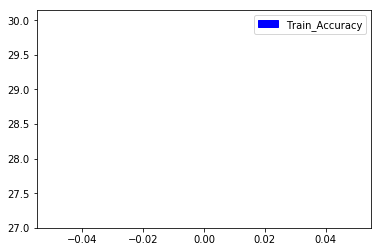

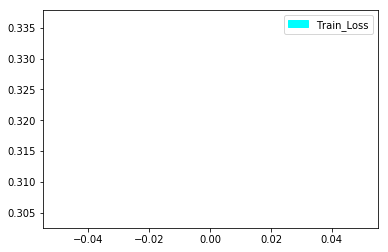

-- Epoch 1/100 --
-- Accuracy 0.0 --
-- correct 0
-- incorrect 7
-- train loss 0.32018426060676575 --


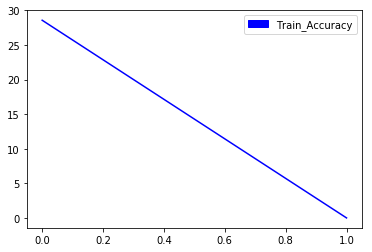

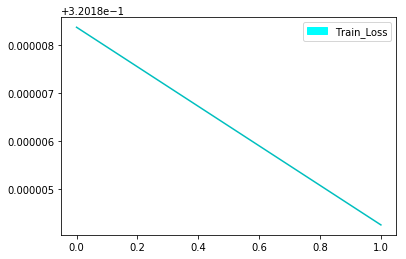

-- Epoch 2/100 --
-- Accuracy 28.57142857142857 --
-- correct 2
-- incorrect 5
-- train loss 0.3201741576194763 --


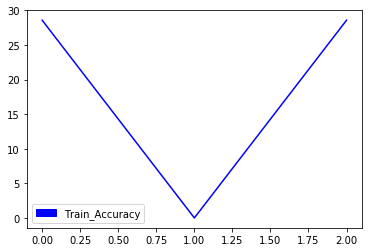

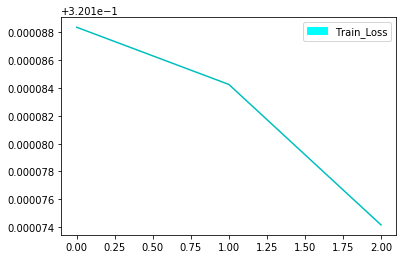

-- Epoch 3/100 --
-- Accuracy 14.285714285714285 --
-- correct 1
-- incorrect 6
-- train loss 0.3201713562011719 --


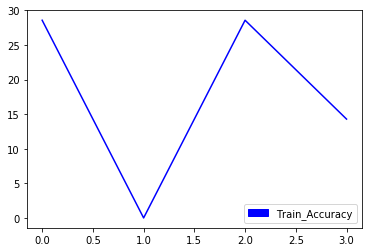

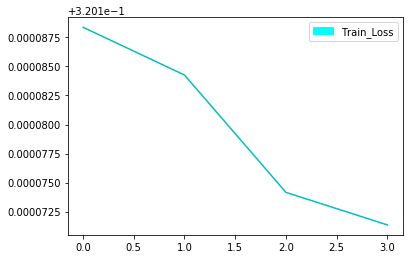

-- Epoch 4/100 --
-- Accuracy 14.285714285714285 --
-- correct 1
-- incorrect 6
-- train loss 0.32014596462249756 --


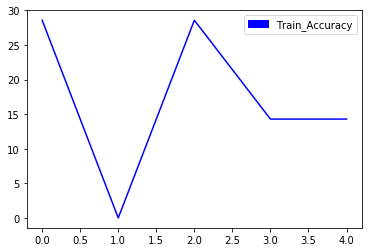

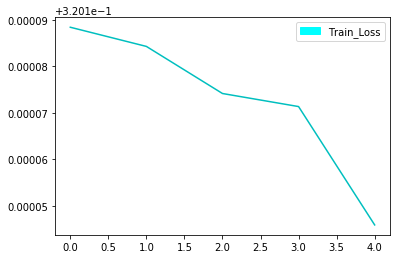

-- Epoch 5/100 --
-- Accuracy 28.57142857142857 --
-- correct 2
-- incorrect 5
-- train loss 0.3201991617679596 --


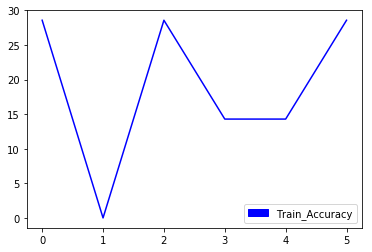

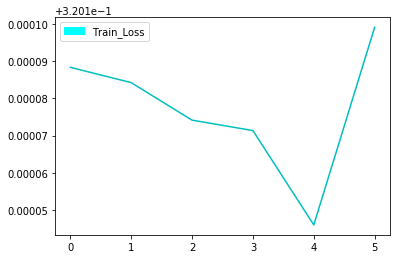

-- Epoch 6/100 --
-- Accuracy 14.285714285714285 --
-- correct 1
-- incorrect 6
-- train loss 0.32016393542289734 --


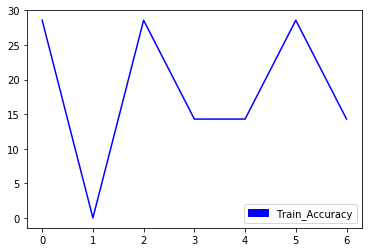

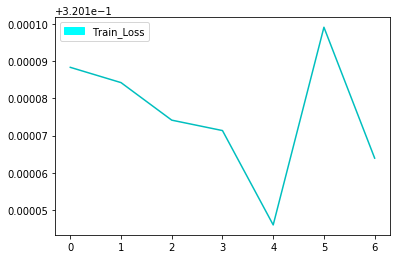

-- Epoch 7/100 --
-- Accuracy 0.0 --
-- correct 0
-- incorrect 7
-- train loss 0.3201659023761749 --


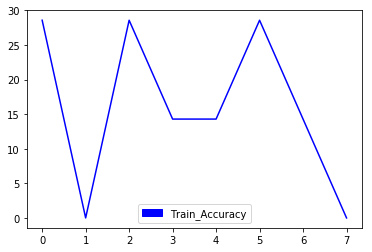

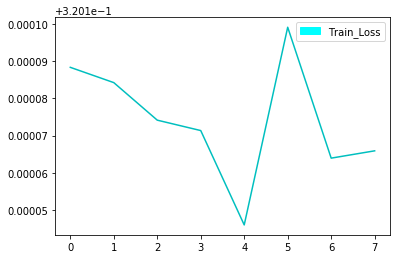

-- Epoch 8/100 --
-- Accuracy 14.285714285714285 --
-- correct 1
-- incorrect 6
-- train loss 0.32020947337150574 --


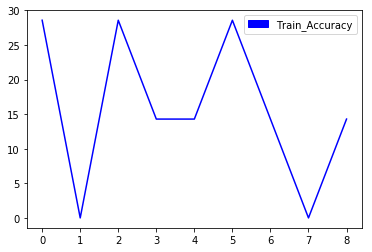

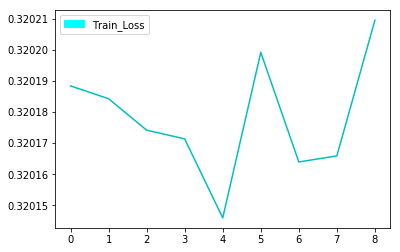

-- Epoch 9/100 --
-- Accuracy 28.57142857142857 --
-- correct 2
-- incorrect 5
-- train loss 0.32019370794296265 --


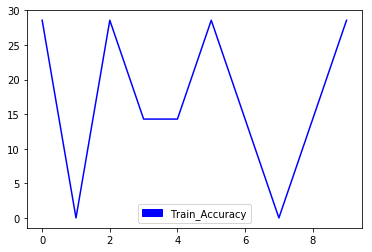

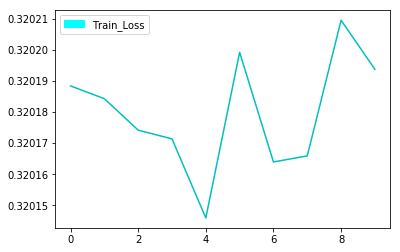

-- Epoch 10/100 --
-- Accuracy 28.57142857142857 --
-- correct 2
-- incorrect 5
-- train loss 0.3201843798160553 --


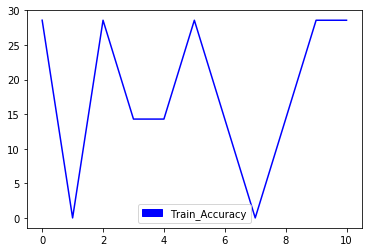

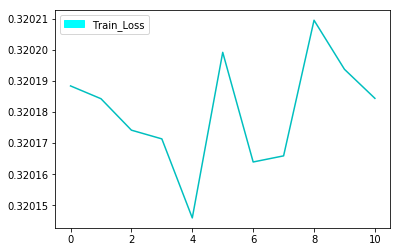

-- Epoch 11/100 --
-- Accuracy 14.285714285714285 --
-- correct 1
-- incorrect 6
-- train loss 0.3202410936355591 --


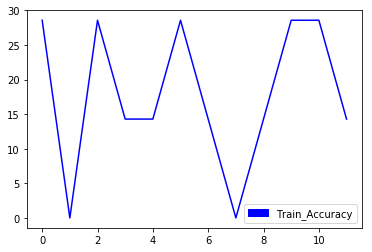

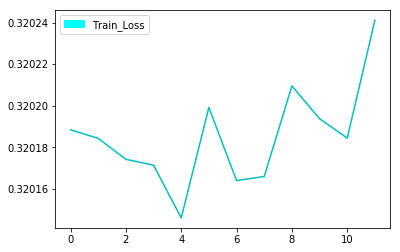

-- Epoch 12/100 --
-- Accuracy 14.285714285714285 --
-- correct 1
-- incorrect 6
-- train loss 0.32016313076019287 --


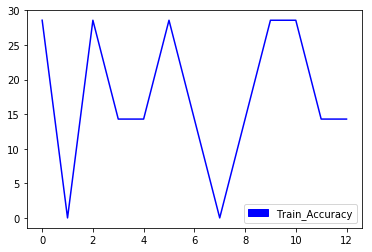

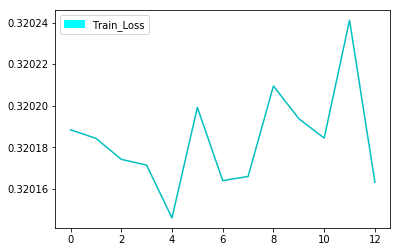

-- Epoch 13/100 --
-- Accuracy 14.285714285714285 --
-- correct 1
-- incorrect 6
-- train loss 0.3201470971107483 --


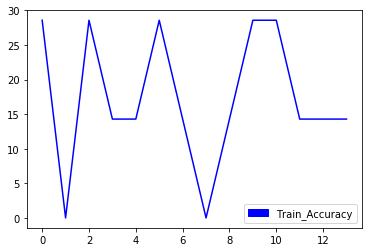

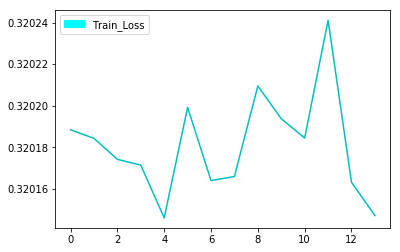

-- Epoch 14/100 --
-- Accuracy 14.285714285714285 --
-- correct 1
-- incorrect 6
-- train loss 0.32020190358161926 --


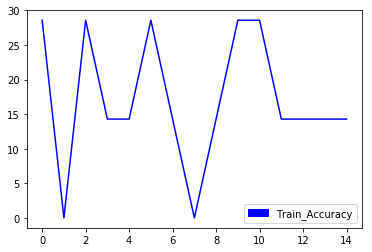

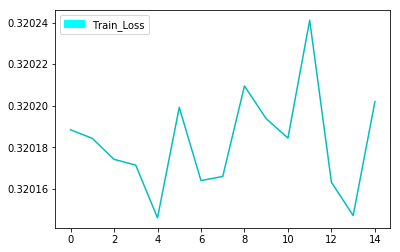

-- Epoch 15/100 --
-- Accuracy 0.0 --
-- correct 0
-- incorrect 7
-- train loss 0.32016631960868835 --


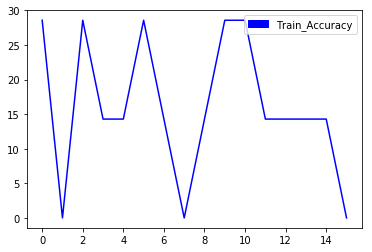

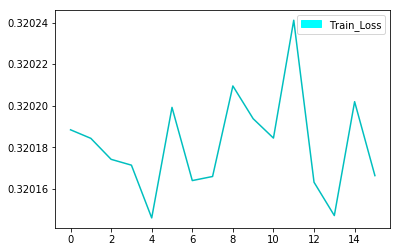

-- Epoch 16/100 --
-- Accuracy 42.857142857142854 --
-- correct 3
-- incorrect 4
-- train loss 0.32018765807151794 --


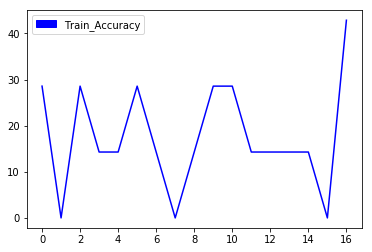

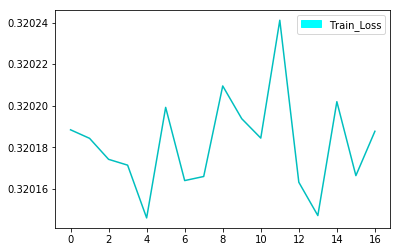

-- Epoch 17/100 --
-- Accuracy 14.285714285714285 --
-- correct 1
-- incorrect 6
-- train loss 0.32018718123435974 --


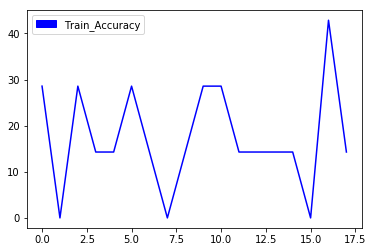

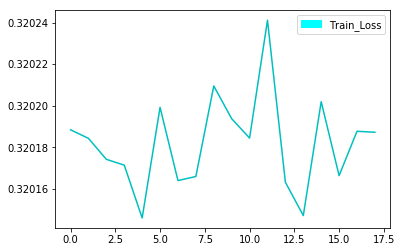

-- Epoch 18/100 --
-- Accuracy 14.285714285714285 --
-- correct 1
-- incorrect 6
-- train loss 0.3201681673526764 --


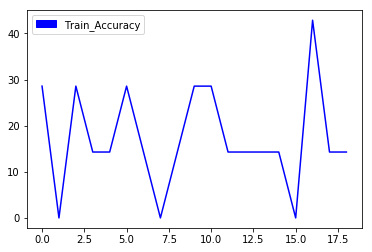

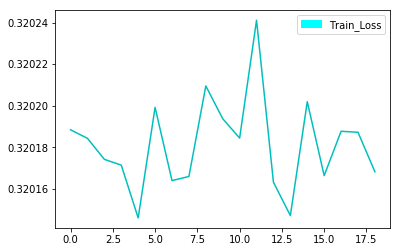

-- Epoch 19/100 --
-- Accuracy 14.285714285714285 --
-- correct 1
-- incorrect 6
-- train loss 0.320182740688324 --


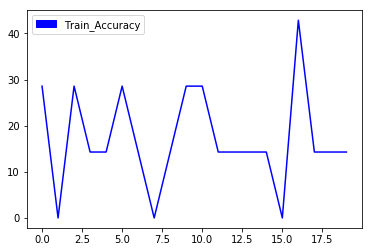

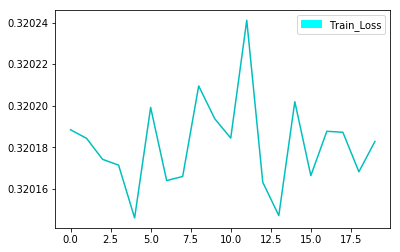

-- Epoch 20/100 --
-- Accuracy 28.57142857142857 --
-- correct 2
-- incorrect 5
-- train loss 0.32015690207481384 --


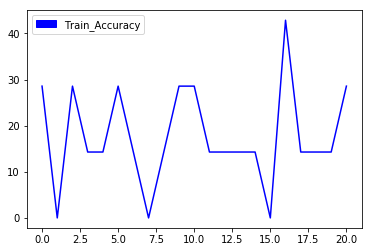

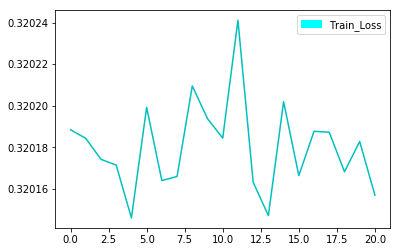

-- Epoch 21/100 --
-- Accuracy 0.0 --
-- correct 0
-- incorrect 7
-- train loss 0.32016804814338684 --


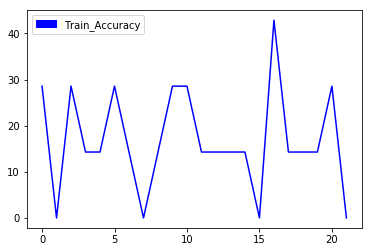

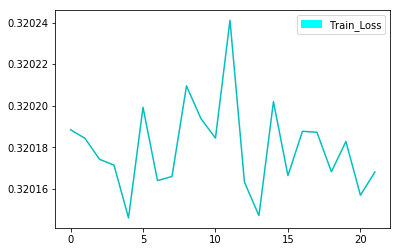

-- Epoch 22/100 --
-- Accuracy 14.285714285714285 --
-- correct 1
-- incorrect 6
-- train loss 0.32016563415527344 --


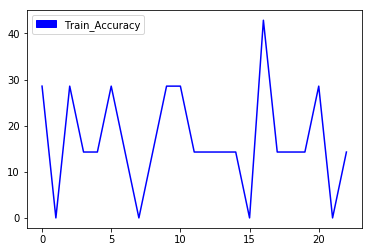

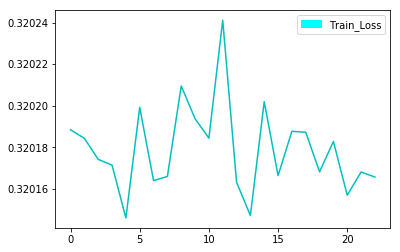

-- Epoch 23/100 --
-- Accuracy 14.285714285714285 --
-- correct 1
-- incorrect 6
-- train loss 0.3201483190059662 --


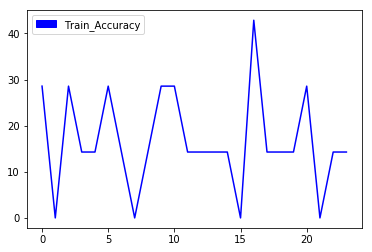

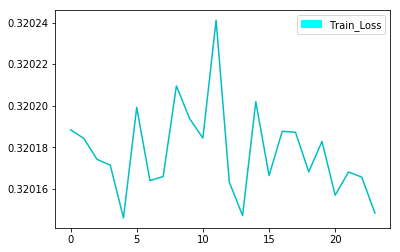

-- Epoch 24/100 --
-- Accuracy 14.285714285714285 --
-- correct 1
-- incorrect 6
-- train loss 0.3201802372932434 --


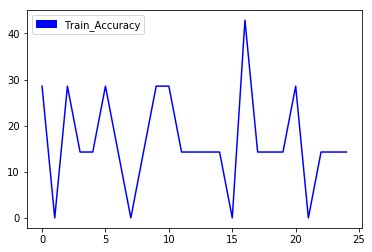

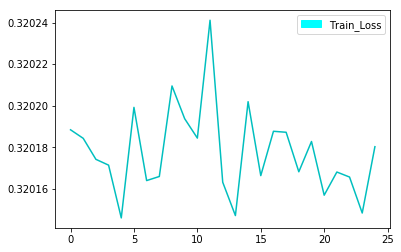

-- Epoch 25/100 --
-- Accuracy 28.57142857142857 --
-- correct 2
-- incorrect 5
-- train loss 0.3201564848423004 --


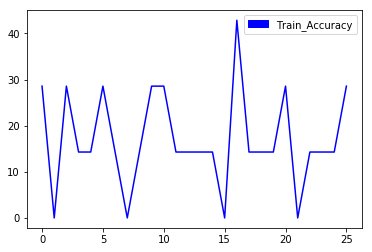

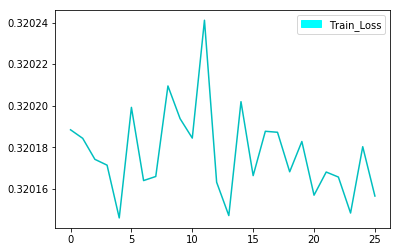

-- Epoch 26/100 --
-- Accuracy 14.285714285714285 --
-- correct 1
-- incorrect 6
-- train loss 0.32024139165878296 --


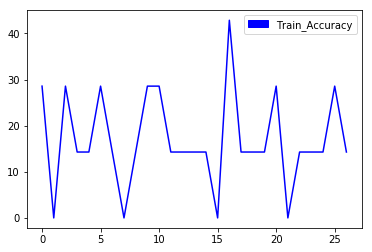

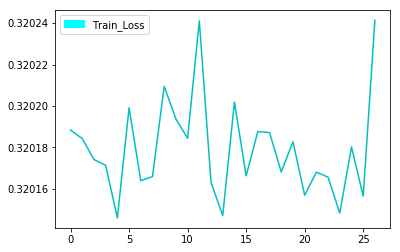

-- Epoch 27/100 --
-- Accuracy 14.285714285714285 --
-- correct 1
-- incorrect 6
-- train loss 0.3201747238636017 --


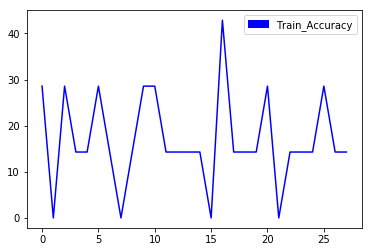

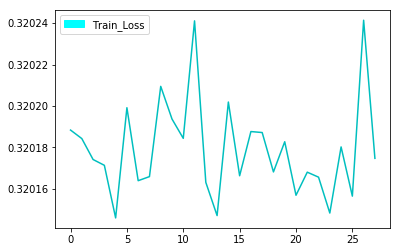

-- Epoch 28/100 --
-- Accuracy 14.285714285714285 --
-- correct 1
-- incorrect 6
-- train loss 0.3201996684074402 --


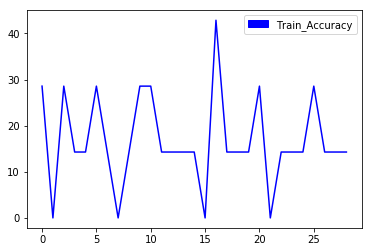

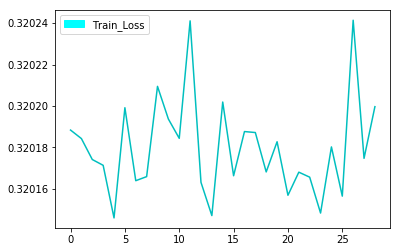

-- Epoch 29/100 --
-- Accuracy 28.57142857142857 --
-- correct 2
-- incorrect 5
-- train loss 0.32019075751304626 --


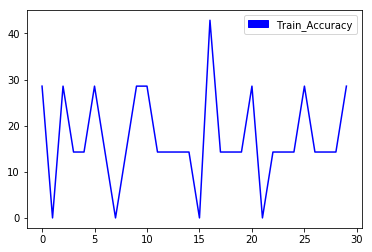

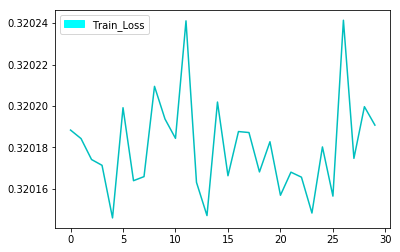

In [ ]:
#train

STEP = 30
LR = 0.0005 #0.00005
model = BoWClassifier(len(word_index),8)
criterion = torch.nn.MultiLabelSoftMarginLoss() 
#criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=LR)
show_loss = []
accuracy = []

print('-- START TRAINING ! --')

for step in range(STEP):
    #model.zero_grad()
    output = model(train_X)
    #output = output.detach().numpy()
    loss = criterion(output,train_y)
    show_loss.append(loss.data)
    a, index = torch.max(output.data,0)
    label=train_y.type(torch.LongTensor)
    
    correct = 0.0
    incorrect = 0.0
    
    for i in range(7):
      if label[i]==index[i]:
        correct+=1
      else:
        incorrect+=1
      
    accuracy.append((correct/(correct+incorrect))*100)    
    

    print('-- Epoch {}/100 --'.format(step))
    print('-- Accuracy {} --'.format((correct/(correct+incorrect))*100))
    print('-- correct {}'.format(int(correct)))
    print('-- incorrect {}'.format(int(incorrect)))
    print('-- train loss {} --'.format(loss.data))
    plt.plot(range(len(accuracy)),accuracy,'b')
    blue_patch = mpatches.Patch(color='blue', label='Train_Accuracy')
    plt.legend(handles=[blue_patch])
    plt.show()
    plt.plot(range(len(show_loss)),show_loss,'c')
    cyan_patch = mpatches.Patch(color='cyan', label='Train_Loss')
    plt.legend(handles=[cyan_patch])
    plt.show()
    loss.backward()
    optimizer.step()

In [ ]:
print(output)

In [ ]:
#test 
test_data =['안구 가려움']

result = {0:'안구건조증',1:'녹내장',2:'백내장',3:'결막염',4:'다래끼',5:'당뇨 망막병증',6:'황반변성',7:'노안'}

with torch.no_grad():  
  for test in test_data:
      X = Variable(make_BoW_count(test,word_index,maxx)).view(1,-1)

      pred = model(X)
      need_value = pred.numpy()
      print(need_value)
      order_in = np.argsort(need_value[0])[::-1]
      for i in order_in:
        print(result[i],':',np.around(need_value[0][i]*100,2),'%')

      #print("Truth : %s" % tes)
      print("\n") 

seqs_token 2
[[0.1275179  0.12345741 0.11884531 0.12536879 0.12956624 0.11884531
  0.11884531 0.13755368]]
노안 : 13.76 %
다래끼 : 12.96 %
안구건조증 : 12.75 %
결막염 : 12.54 %
녹내장 : 12.35 %
황반변성 : 11.88 %
당뇨 망막병증 : 11.88 %
백내장 : 11.88 %




/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
need_value = pred.numpy()
np.around(need_value[0][1]*100,2)

In [ ]:
result = {0:'안구건조증',1:'녹내장',2:'백내장',3:'결막염',4:'다래끼',5:'당뇨 망막병증',6:'황반변성',7:'노안'}
print(need_value)
order_in = np.argsort(need_value[0])[::-1]
print(order_in)

for i in order_in:
  print(result[i],':',np.around(need_value[0][i]*100,2),'%')

In [ ]:
netc.cuda()
print(netc)